# Fitting

In [ ]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import Operator
from tqdm.notebook import tqdm

from kraus_channels import KrausMap, isomery_to_kraus
from loss_functions import ProbabilityMSE, ProbabilityRValue
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import channel_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, CorruptionMatrix
from utils import saver
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio
from quantum_circuits import integrable_circuit


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
def integrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.rz(theta[j], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def nonintegrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, 2*n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.ry(theta[j], j)
            circuit.rz(theta[j+n], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit

In [7]:
def load_data(filename, n, seed, L):
    with open(filename, 'rb') as f:
        data = pkl.load(f)


    data = marginalize_counts(data, 0)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(seed)
    
    circuit_target = integrable_circuit(n+1, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 3000,
             verbose = False):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = verbose,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 3000,
              verbose=False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=verbose
                )
    
    return model

In [ ]:
path = 'data/chaos_exp_reorder/5q/integrable_L=20/'
n = 4
d = 2**n
L = 20

spam_list = []
model_list = []

for i in tqdm(range(10)):
    seed = 42 + i
    inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data(path + f'seed_{seed}.pkl', n, seed, L)
    spam_model = fit_spam(inputs_spam, targets_spam, verbose=True)
    spam_list.append(spam_model) 

    model = fit_model(inputs_map, 
                     targets_map, 
                     spam_model, 
                     verbose=True)
    model_list.append(model)

model_saver(spam_list, f'models/integrable_spam_{n}_L=20_reorder.model')
model_saver(model_list, f'models/integrable_model_{n}_L=20_reorder.model')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.05576614623180693 
0.0009557960380752149 
0.00010871440703327902 
9.010121412542241e-05 
8.201553865862807e-05 
7.78468455591827e-05 
7.55636141738481e-05 
7.422151969479721e-05 
7.328257537258364e-05 
7.264731311837578e-05 
7.22059480108819e-05 
7.193980772102246e-05 
7.166594973098953e-05 
7.144895844600901e-05 
7.128808591483204e-05 
7.116436318286972e-05 
7.105445151374252e-05 
7.095592731529857e-05 
7.086784101555369e-05 
7.078289200760836e-05 
7.072532507857608e-05 
7.067445279682866e-05 
7.062858268830969e-05 
7.059865418239215e-05 
7.054958237965914e-05 
7.052821932908486e-05 
7.049582497448775e-05 
7.047351825831697e-05 
7.044933682462994e-05 
7.044741234989106e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.003151637350781167]
[0.6684766888567262]
[0.9350722622307156]
[0.9799943548561237]
[0.9867549562148138]
[0.9890215836647589]
[0.990146739097712]
[0.99084613508421]
[0.9913300256630574]
[0.9916924125642921]
[0.9919717725836327]
[0.9921833369717542]
[0.9923620868418158]
[0.9925039417840199]
[0.9926316411994066]
[0.9927297100760312]
[0.99282251902809]
[0.9928927190072036]
[0.9929676345060386]
[0.9930155174273945]
[0.9930672852008721]
[0.9931062284224749]
[0.9931515481369867]
[0.9931752548398272]
[0.9932100800094779]
[0.9932331282387167]
[0.9932552517348026]
[0.9932610847706986]
[0.9932772868748617]
[0.9932998607211433]
[0.9933098013679121]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06154977665522599 
0.0007747453470093738 
8.18435647838591e-05 
7.815943378840779e-05 
7.594181293987111e-05 
7.447928729671294e-05 
7.341856188849468e-05 
7.268529073584103e-05 
7.215482708241067e-05 
7.175585258793025e-05 
7.149821304258225e-05 
7.12723350796268e-05 
7.109409095627323e-05 
7.09574434035314e-05 
7.085091555605495e-05 
7.075815564627354e-05 
7.068478892440424e-05 
7.061107495351878e-05 
7.05756092085768e-05 
7.05283687790618e-05 
7.049699970539183e-05 
7.048088897655466e-05 
7.044319877240422e-05 
7.043128365659481e-05 
7.041032400519165e-05 
7.039689641579249e-05 
7.038596236727815e-05 
7.036630622944119e-05 
7.035967364194805e-05 
7.03516229386993e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.005222936335854245]
[0.6646502763670677]
[0.9470844910843867]
[0.9829735846021235]
[0.9877554082145489]
[0.9895475015930951]
[0.9905179077934383]
[0.991143961299029]
[0.9915764777459327]
[0.9919052656581601]
[0.9921643284416809]
[0.9923777260988332]
[0.9925467908342817]
[0.9926754380260415]
[0.9927982638769937]
[0.9928886225194838]
[0.9929769709335752]
[0.9930569226120864]
[0.9931148333626647]
[0.9931548385063699]
[0.9932175687695742]
[0.9932400125848021]
[0.9932831591923351]
[0.993313334833425]
[0.993325872002239]
[0.9933616029175458]
[0.9933620226878691]
[0.9933989607307804]
[0.9934147438960499]
[0.9934274578571117]
[0.9934374115042977]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06559351434011684 
0.005491285563055177 
8.353391352340147e-05 
7.806258787410115e-05 
7.589194385184063e-05 
7.450545259581031e-05 
7.353782360345075e-05 
7.283116672287268e-05 
7.232274340875104e-05 
7.193093078840718e-05 
7.163890305563374e-05 
7.140834401792162e-05 
7.11994538793804e-05 
7.106294079749323e-05 
7.094377488986958e-05 
7.086483274827369e-05 
7.07792943825308e-05 
7.070705496760599e-05 
7.066131314516963e-05 
7.060071382784823e-05 
7.054627688840759e-05 
7.051696371844973e-05 
7.049429564254084e-05 
7.046747654491513e-05 
7.0437473148376e-05 
7.042644927192117e-05 
7.04029634282835e-05 
7.039149362713197e-05 
7.036642650683112e-05 
7.037983455526302e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[0.004984605890396732]
[0.6851948344899226]
[0.929168096144902]
[0.9789203379981406]
[0.9870176073294701]
[0.989725559509118]
[0.9910466272130445]
[0.9918223513206782]
[0.9923416089238691]
[0.9927130226612316]
[0.9930004468802159]
[0.9932321150151715]
[0.9934038559957913]
[0.9935482219059792]
[0.993680734470293]
[0.9937821871451069]
[0.9938732009664146]
[0.9939486236867803]
[0.994009749734293]
[0.9940648077865871]
[0.9941128271772975]
[0.9941640446740239]
[0.9942007848545897]
[0.9942227443153664]
[0.9942573765402878]
[0.9942895855838304]
[0.9943045510615841]
[0.9943195149925325]
[0.9943427142438879]
[0.9943565161756447]
[0.9943693067865078]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.06360912000725896 
0.004776565475264075 
0.0001067574801316417 
7.591060954770078e-05 
7.479487271432686e-05 
7.395044310235148e-05 
7.328934117971828e-05 
7.275134400321981e-05 
7.23389177849232e-05 
7.200477282339127e-05 
7.173859992692808e-05 
7.151250657303156e-05 
7.132305159238242e-05 
7.117824650058736e-05 
7.103865528865505e-05 
7.092129782015631e-05 
7.083417123866513e-05 
7.075829522381167e-05 
7.068421557642881e-05 
7.064306446772232e-05 
7.057469438827543e-05 
7.054492598394731e-05 
7.051382613405593e-05 
7.047304581723148e-05 
7.04513002738774e-05 
7.043422057748118e-05 
7.041744086590443e-05 
7.039036492257558e-05 
7.039244953246855e-05 
7.038692869702889e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.0018963781275378455]
[0.6368825905072182]
[0.9246628421284798]
[0.9797011316870587]
[0.9874239987439641]
[0.9898582728165352]
[0.9910268038973248]
[0.9917208173660786]
[0.992207499860585]
[0.992553344163852]
[0.9928185372208551]
[0.9930237904965593]
[0.9931978354777519]
[0.9933339862934288]
[0.9934572307981225]
[0.9935551672188896]
[0.9936224526714124]
[0.9936932024551197]
[0.9937548194315481]
[0.9938101415639217]
[0.9938520701914696]
[0.9938844955522769]
[0.9939270343751407]
[0.9939605016155003]
[0.9939817744714593]
[0.9940058725310174]
[0.9940161652786592]
[0.9940465161287855]
[0.9940570203658609]
[0.9940599295223707]
[0.9940694526094713]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.08249123818036602 
0.005907854083530828 
0.0001012071478862652 
7.720896585189042e-05 
7.572905726882548e-05 
7.468046057533417e-05 
7.381797686489587e-05 
7.315464686523955e-05 
7.261234651883538e-05 
7.221633278343431e-05 
7.190326536120486e-05 
7.159145187537868e-05 
7.139271494030662e-05 
7.121258491781981e-05 
7.10750622751212e-05 
7.094284393401344e-05 
7.08616939524807e-05 
7.078043046903986e-05 
7.07097145907001e-05 
7.064544951380102e-05 
7.059418943385496e-05 
7.055500803768471e-05 
7.053127913268214e-05 
7.050748488663866e-05 
7.048868778690353e-05 
7.048160636481051e-05 
7.044210532802224e-05 
7.042356987396602e-05 
7.043205038037211e-05 
7.040736131558855e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[0.006693832721452853]
[0.6575979140646337]
[0.9357292149222057]
[0.9824532977858873]
[0.9890897996282796]
[0.9912574282559347]
[0.9923321781399083]
[0.9929919455547165]
[0.9934548844345996]
[0.9937872698041156]
[0.9940502977661748]
[0.9942501097635378]
[0.994415023151551]
[0.9945498558928639]
[0.9946612590956386]
[0.994764504545317]
[0.9948485239300457]
[0.9949170026342194]
[0.9949806732292176]
[0.9950262012424252]
[0.9950739942249505]
[0.9951121556330221]
[0.9951532342406847]
[0.9951856970787097]
[0.9952121821805395]
[0.9952336537947818]
[0.9952595336217008]
[0.9952777732587125]
[0.9952984409820961]
[0.9953083302267925]
[0.9953120768045484]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.0782367041948823 
0.006314235610039046 
0.00010793413454697033 
8.458395860373105e-05 
8.039916864820292e-05 
7.741068569177775e-05 
7.556673869953809e-05 
7.417016559099476e-05 
7.326023065886535e-05 
7.262874564414565e-05 
7.204900549453351e-05 
7.168945079734644e-05 
7.133425466102282e-05 
7.116909790932732e-05 
7.092135712819143e-05 
7.078313303963809e-05 
7.070231774870512e-05 
7.062704460225101e-05 
7.057910234095645e-05 
7.05341068341164e-05 
7.046768248216356e-05 
7.044304349402569e-05 
7.041402673646071e-05 
7.039755258530329e-05 
7.0383208196363e-05 
7.038224358256855e-05 
7.035639187591564e-05 
7.035265987609372e-05 
7.03390023546256e-05 
7.034313890633325e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[0.0032121307848542724]
[0.6630459946531786]
[0.9499209600541567]
[0.9816470694103708]
[0.9862041453658408]
[0.9880352568383775]
[0.989065624838893]
[0.9897299223387072]
[0.9902055252289055]
[0.9905608323052176]
[0.9908412535936907]
[0.9910631805176872]
[0.9912493178677502]
[0.9913920355369027]
[0.991517467347463]
[0.9916087608086271]
[0.9916988910166358]
[0.9917734944807987]
[0.9918306029929953]
[0.9918947860306032]
[0.9919328756262441]
[0.9919854503179794]
[0.9920165458674364]
[0.9920444549160311]
[0.9920714032406646]
[0.9920819618381926]
[0.99211431456141]
[0.992116484638421]
[0.9921471441423061]
[0.9921576050232872]
[0.9921741242337961]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.05921799038930411 
0.003686705023532875 
9.64851453376648e-05 
8.767331740738316e-05 
8.288125885195449e-05 
7.955590142096121e-05 
7.730912133811428e-05 
7.578281772768765e-05 
7.453079513402232e-05 
7.372115774931973e-05 
7.308596008389609e-05 
7.256011751954253e-05 
7.214268602020401e-05 
7.181974934238407e-05 
7.15687866298479e-05 
7.140127611282498e-05 
7.124661458511804e-05 
7.112598735408428e-05 
7.098721456240107e-05 
7.089778425988142e-05 
7.081356268817654e-05 
7.075762191486455e-05 
7.071140131344887e-05 
7.06269955223952e-05 
7.062507699481434e-05 
7.056223872616796e-05 
7.05657107599794e-05 
7.051776410849752e-05 
7.050578990277398e-05 
7.04833437725126e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.002858952002332771]
[0.6543317816695895]
[0.9438368868359678]
[0.9872577873700867]
[0.9924922068548145]
[0.9941950646534524]
[0.9950265926244966]
[0.9955220532115157]
[0.9958552762433948]
[0.9960938567555586]
[0.9962755837699946]
[0.996417691590226]
[0.9965324988566339]
[0.9966242802542309]
[0.9966990066133707]
[0.9967689690401473]
[0.996825420424184]
[0.9968712448506547]
[0.9969152749121779]
[0.9969543540487887]
[0.996982850834554]
[0.9970130706884364]
[0.9970340074719845]
[0.9970602626461654]
[0.9970799867547386]
[0.9970987313189204]
[0.9971065480374378]
[0.9971235288144674]
[0.9971361113276507]
[0.9971519893805418]
[0.9971540498997256]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.07899500494390228 
0.006602691375169882 
0.00020723568000917823 
8.822021890081209e-05 
8.321580922525086e-05 
7.993126284823686e-05 
7.762359748694548e-05 
7.604277987060709e-05 
7.488992841165869e-05 
7.404452378017337e-05 
7.339562718948859e-05 
7.286709824821105e-05 
7.2517416400111e-05 
7.215581813800458e-05 
7.190430388194402e-05 
7.16615656028245e-05 
7.144146100518794e-05 
7.132170180231037e-05 
7.118395768010546e-05 
7.108314845899558e-05 
7.096386615686301e-05 
7.085305363932563e-05 
7.080122948531349e-05 
7.074045235827131e-05 
7.06945988119176e-05 
7.061266290140217e-05 
7.057657817890296e-05 
7.055308647609408e-05 
7.053403638835132e-05 
7.049616351201083e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.000998927033639685]
[0.6499149938303437]
[0.9418385981727447]
[0.9864967735611135]
[0.9920179229733288]
[0.9938458217139057]
[0.994735302019075]
[0.9952647495888437]
[0.9956137585002863]
[0.9958701070101355]
[0.9960628970248863]
[0.9962119654211662]
[0.9963340074826359]
[0.9964339734399028]
[0.9965141449562032]
[0.996582349445817]
[0.9966373540943156]
[0.9966888016352048]
[0.9967418128278213]
[0.996776602894726]
[0.9968069202497165]
[0.9968376043658498]
[0.9968648929286612]
[0.9968819394974949]
[0.9969076338157041]
[0.9969199593459133]
[0.9969376895333691]
[0.9969563910656527]
[0.9969617281077738]
[0.9969763578659783]
[0.9969822984843154]


  0%|          | 0/3000 [00:00<?, ?it/s]

0.05325706171881462 
0.0015768091449978648 
9.920406142844258e-05 
8.744429633625996e-05 
8.162890283505338e-05 
7.812321307782528e-05 
7.622102070817403e-05 
7.475130493423704e-05 
7.383251992035326e-05 
7.314117169208959e-05 
7.258683819204607e-05 
7.218316159663342e-05 
7.185231033203405e-05 
7.165062513561253e-05 
7.142857192719605e-05 
7.123315919476464e-05 
7.109483149242403e-05 
7.099793109106632e-05 
7.089079645100147e-05 
7.081650260363633e-05 
7.075813248897895e-05 
7.068351019219459e-05 
7.065552980631811e-05 
7.060135463254373e-05 
7.055233518945869e-05 
7.055993713683504e-05 
7.051478732912068e-05 
7.049125307860099e-05 
7.046330356044477e-05 
7.044853066866242e-05 


  0%|          | 0/3000 [00:00<?, ?it/s]

[0.0007770441544074913]
[0.6253223654355925]
[0.9408340964304264]
[0.9818667499543059]
[0.9881175057304699]
[0.9901737518150389]
[0.9912188091640828]
[0.9918740567881237]
[0.9923244205187389]
[0.992660716110352]
[0.9929180767203997]
[0.9931182472394394]


## Retrieve CSR

### L = 20

In [9]:
n = 4

model_list = pkl.load(open(f'models/integrable_model_{n}_L=20_reorder.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)

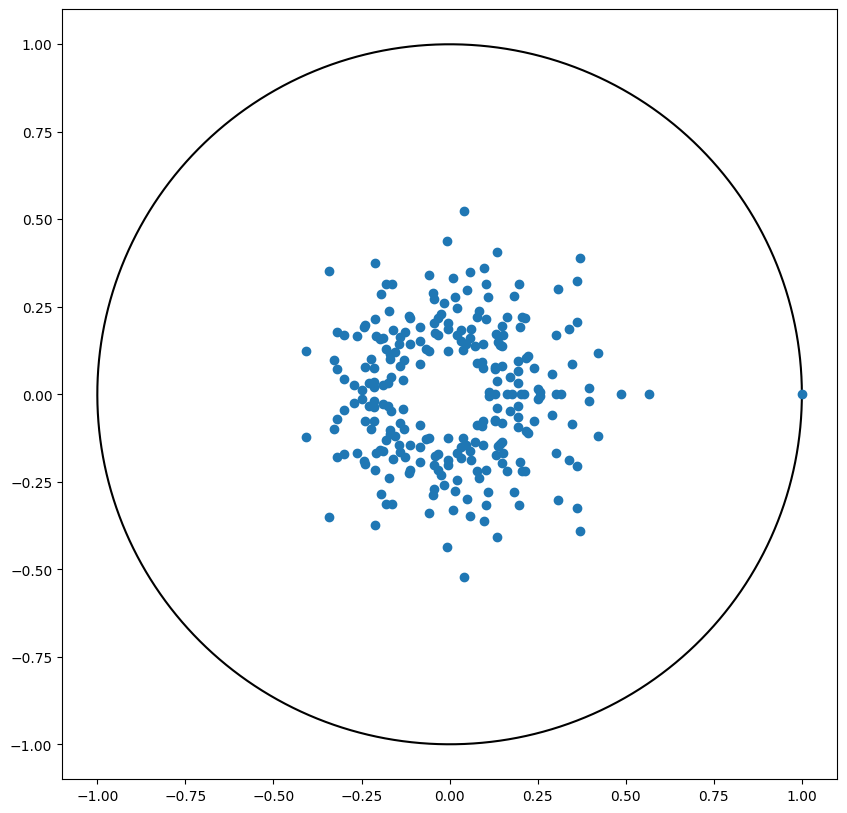

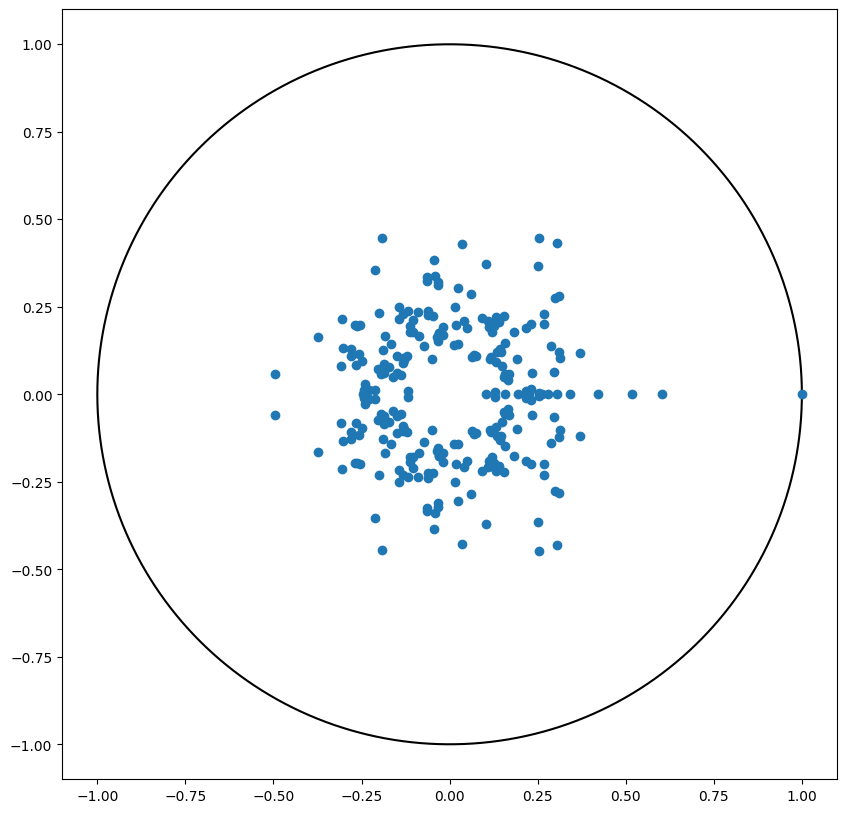

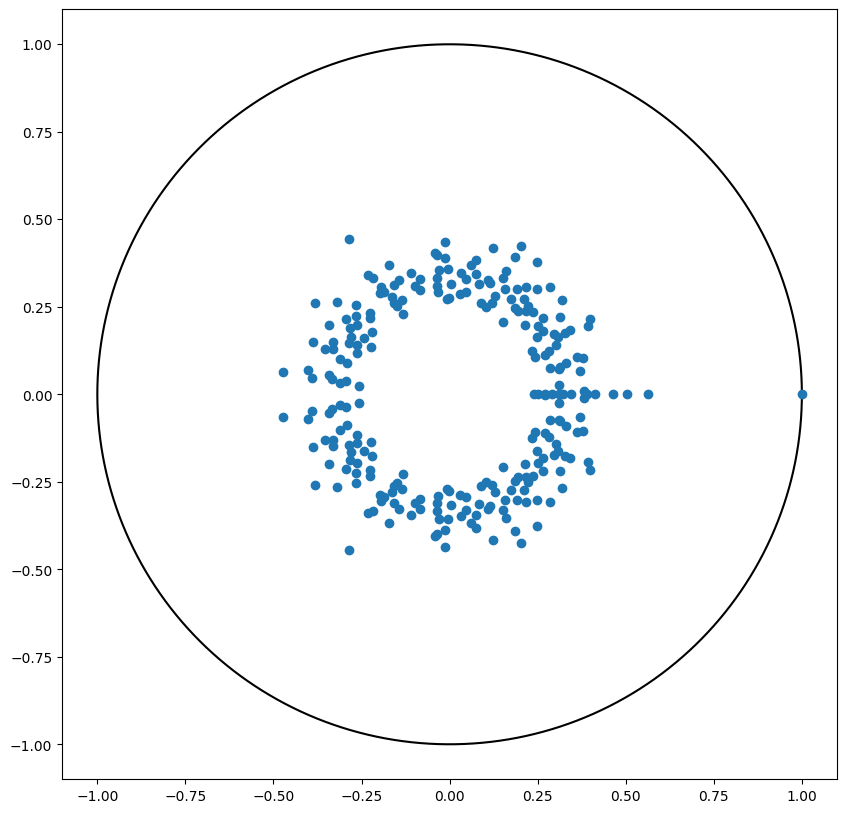

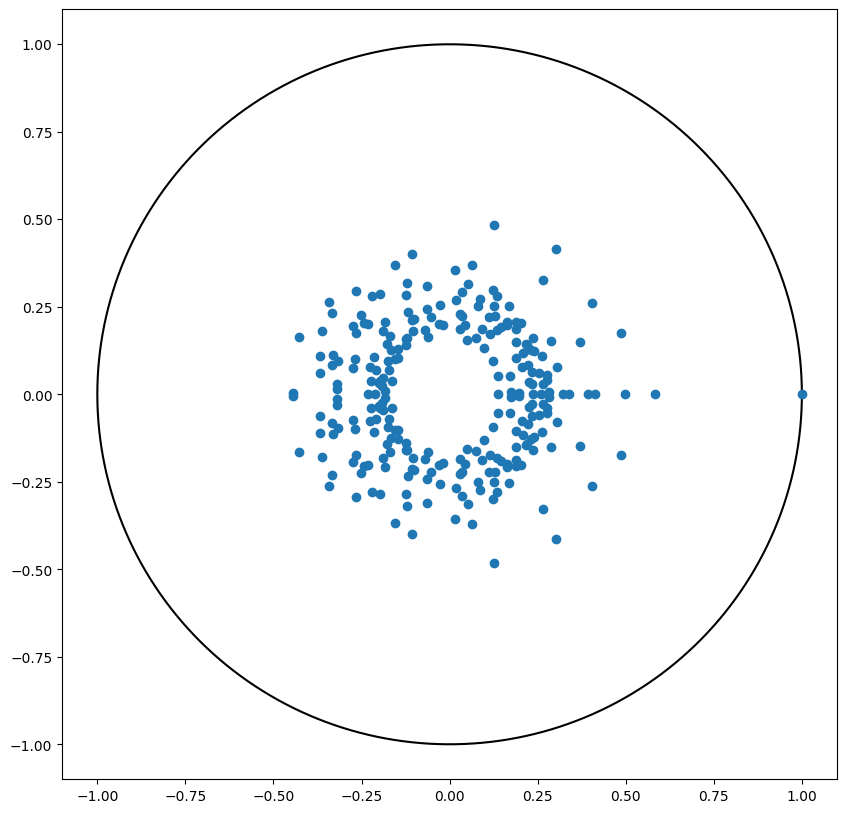

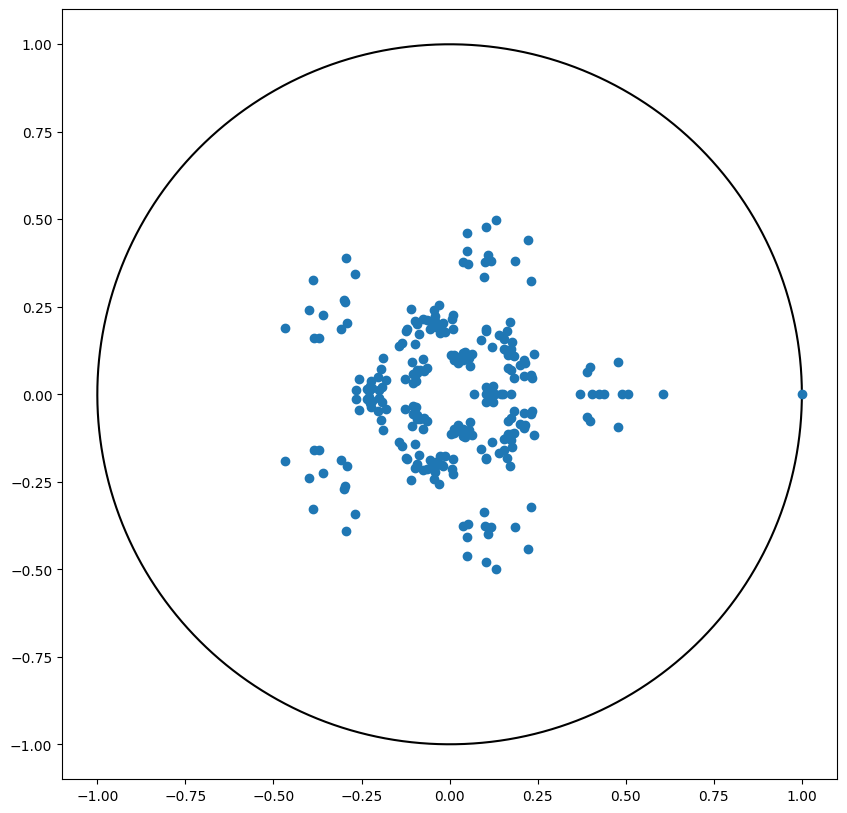

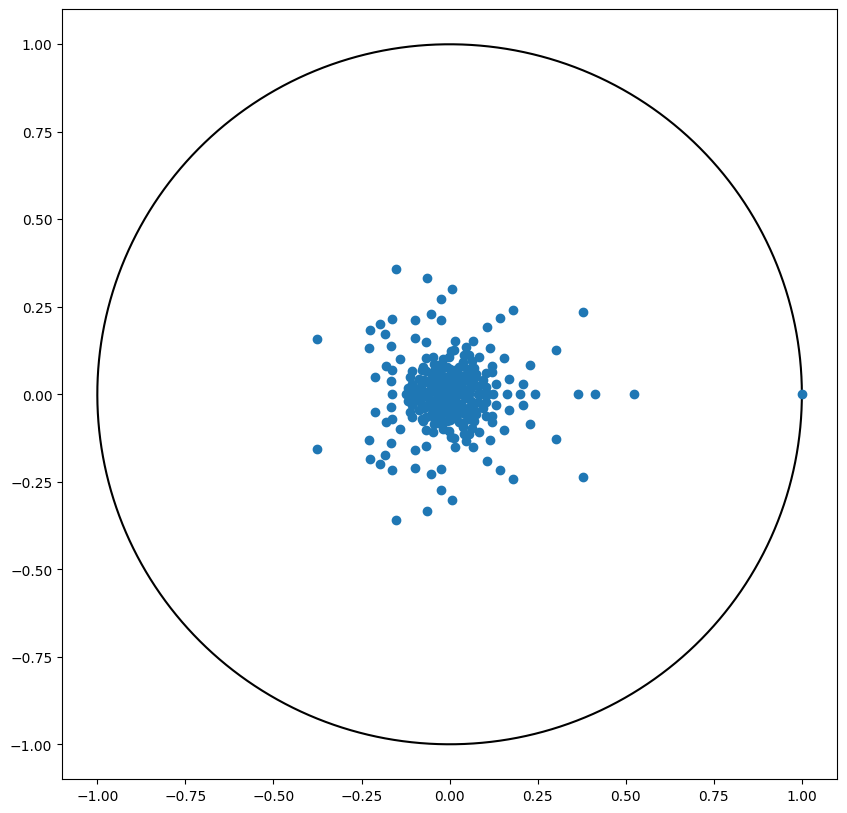

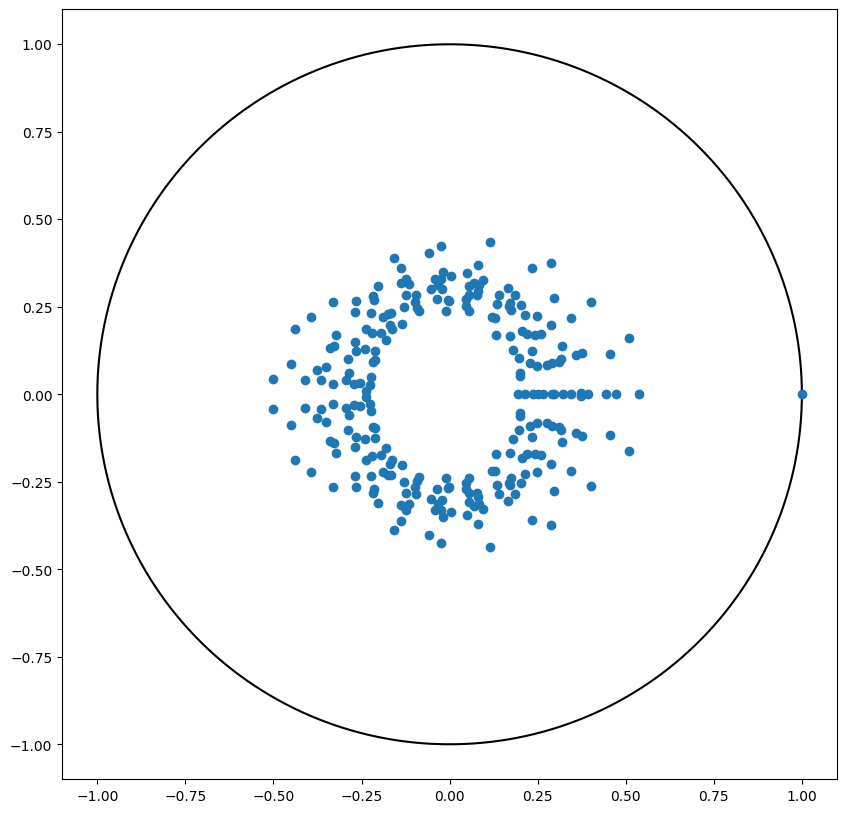

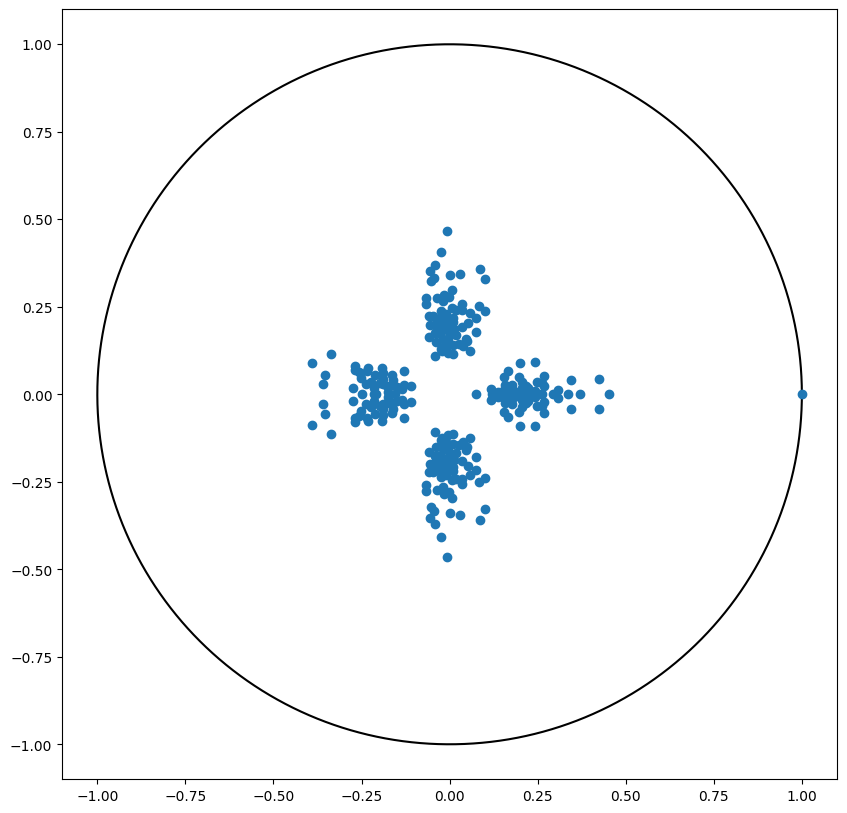

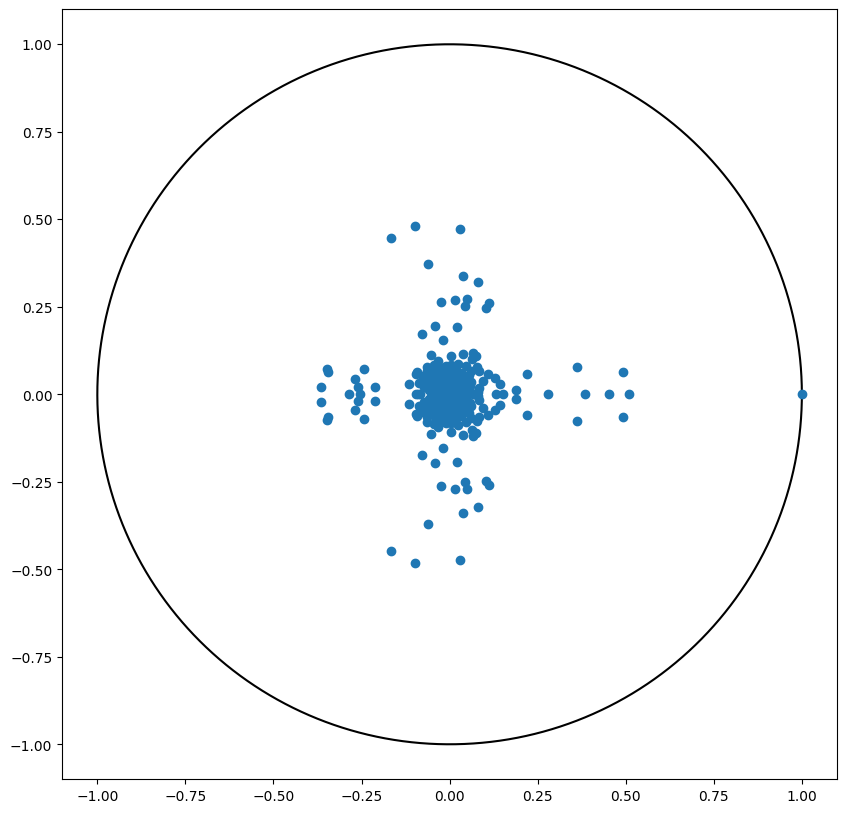

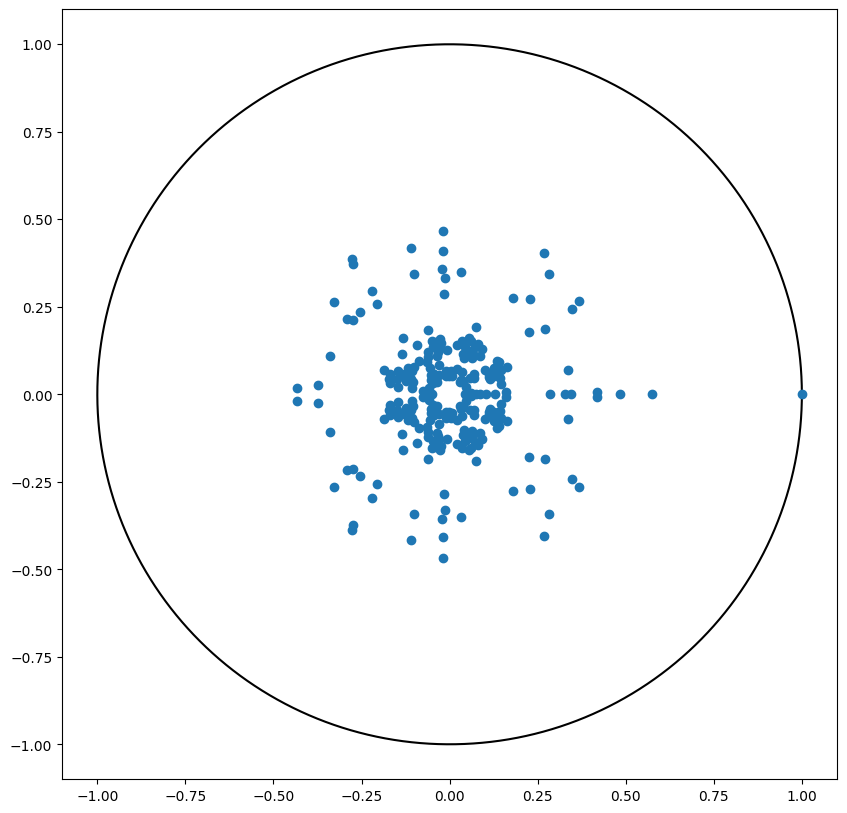

In [6]:
for spectrum in spectrum_list:
    spectrum.plot_circle()
    spectrum.plot()
    plt.show()

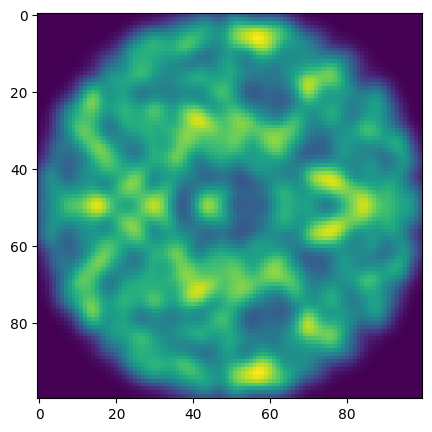

In [7]:
csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=20.png')
plt.show()

In [10]:
loss_mean = np.mean(loss_list)
loss_std = np.std(loss_list)

print(f'Loss mean: {loss_mean}, Loss std: {loss_std}')

Loss mean: 0.9918681256668321, Loss std: 0.0017883331206181587


In [10]:
for i, model in enumerate(model_list):
    SO = model.channel.superoperator
    np.savetxt(f'models/superoperator_L=20/superoperator{i}', SO, fmt='%f')